In [1]:
import yfinance as yf
import datetime as dt
import pandas_datareader as pdr
import pandas as pd
import pandas_ta as pta
import matplotlib.pyplot as plt
import numpy as np


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, Conv2D, Flatten, MaxPooling1D
from tensorflow.keras.optimizers import SGD

In [2]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\FileBase")

from root_functions import add_indicators, up_down, full_prediction, result

## Descarga datos y creación dataset

In [3]:
sample_per = 400
stock = 'EURGBP=X'

end = dt.date.today()- dt.timedelta(days=2)
start = end - dt.timedelta(days=(sample_per))
interval = '1h'

In [4]:
database = yf.download(stock, start=start, end=end, interval=interval)

[*********************100%***********************]  1 of 1 completed


In [5]:
#Añadimos indicadores

ema1=200
ema2=50
ema3=20

data_base = add_indicators(database)

#Añadimos columna up_down
data_base = up_down(data_base)

#Listado indicadores
data_base.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', '200ema',
       '50ema', '20ema', '14-high', '14-low', '%K', '%D', 'RSI', 'MACD',
       'MACDh', 'MACDs', 'CCI', 'PSAR', 'BBl', 'BBm', 'BBu', 'BBb', 'BBp',
       'ATR', 'log_ret', 'Up_Down'],
      dtype='object')

In [6]:
data_base.iloc[:,7:]

,50ema,20ema,14-high,14-low,%K,%D,RSI,MACD,MACDh,MACDs,CCI,PSAR,BBl,BBm,BBu,BBb,BBp,ATR,log_ret,Up_Down
2020-07-27 00:00:00+01:00,0.910470,0.910470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2020-07-27 01:00:00+01:00,0.910525,0.910604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.912440,NaN,NaN,NaN,NaN,NaN,NaN,0.001549,1
2020-07-27 02:00:00+01:00,0.910555,0.910669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.912440,NaN,NaN,NaN,NaN,NaN,NaN,-0.000658,0
2020-07-27 03:00:00+01:00,0.910588,0.910739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.912440,NaN,NaN,NaN,NaN,NaN,NaN,0.000143,1
2020-07-27 04:00:00+01:00,0.910636,0.910841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.912393,0.910361,0.911370,0.912379,0.221493,0.717965,NaN,0.000439,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-30 18:00:00+01:00,0.857211,0.857396,0.8582,0.85660,59.376397,55.416480,52.822892,0.000095,0.000024,0.000070,38.361801,-0.858066,0.857299,0.857506,0.857713,0.048169,0.606581,0.000818,-0.000058,0
2021-08-30 19:00:00+01:00,0.857217,0.857393,0.8582,0.85660,47.500373,56.458302,50.026294,0.000080,0.000008,0.000072,-24.261354,-0.858040,0.857240,0.857478,0.857716,0.055461,0.251888,0.000793,-0.000222,0
2021-08-30 20:00:00+01:00,0.857228,0.857402,0.8582,0.85660,55.625093,54.167288,51.902383,0.000078,0.000004,0.000073,-16.649434,-0.858015,0.857241,0.857462,0.857683,0.051558,0.563340,0.000770,0.000152,1
2021-08-30 21:00:00+01:00,0.857230,0.857392,0.8582,0.85680,35.711853,46.279106,49.006299,0.000060,-0.000011,0.000071,-84.660558,-0.857991,0.857233,0.857460,0.857687,0.052861,0.146970,0.000769,-0.000222,0


In [7]:
#Hacemos un shift a la columna Up_Down para tener el signo de la tendencia de la siguiente vela
data_base['Up_Down'] = data_base['Up_Down'].shift(-1)

data_base.dropna(inplace=True)

In [8]:
#Filtramos las columnas que nos interesan para obtener el dataset de trabajo
data = data_base.copy()

#f'{ema1}ema', f'{ema2}ema', f'{ema3}ema'
data = data[['Up_Down','Adj Close', f'{ema1}ema', f'{ema2}ema', f'{ema3}ema', '14-high', '14-low', '%K', '%D', 'RSI', 'MACD',
       'MACDh', 'MACDs', 'CCI', 'PSAR', 'BBl', 'BBm', 'BBu', 'BBb', 'BBp',
       'ATR', 'log_ret']]


cols = data.columns

In [9]:
data

,Up_Down,Adj Close,200ema,50ema,20ema,14-high,14-low,%K,%D,RSI,...,MACDs,CCI,PSAR,BBl,BBm,BBu,BBb,BBp,ATR,log_ret
2020-07-28 09:00:00+01:00,1.0,0.91002,0.912072,0.911659,0.911917,0.9136,0.90970,8.205465,24.803092,36.104221,...,0.000175,-246.061306,-0.913891,0.909754,0.911530,0.913306,0.389675,0.074891,0.001438,-0.001350
2020-07-28 10:00:00+01:00,1.0,0.91113,0.912041,0.911639,0.911842,0.9136,0.90909,45.232998,27.508029,45.114528,...,0.000103,-163.191202,-0.913724,0.909729,0.911272,0.912815,0.338748,0.454006,0.001505,0.001220
2020-07-28 11:00:00+01:00,0.0,0.91122,0.912014,0.911622,0.911783,0.9136,0.90909,47.228610,33.555691,45.782137,...,0.000041,-79.803956,-0.913446,0.909983,0.911032,0.912081,0.230219,0.589644,0.001495,0.000099
2020-07-28 12:00:00+01:00,1.0,0.90989,0.911945,0.911554,0.911602,0.9136,0.90909,17.738482,36.733363,38.357146,...,-0.000034,-129.051595,-0.913184,0.909477,0.910702,0.911927,0.269061,0.168616,0.001573,-0.001460
2020-07-28 13:00:00+01:00,0.0,0.91047,0.911899,0.911512,0.911495,0.9136,0.90909,30.598948,31.855347,42.719971,...,-0.000102,-124.054582,-0.912939,0.909448,0.910546,0.911644,0.241267,0.465407,0.001562,0.000637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-30 17:00:00+01:00,0.0,0.85760,0.855717,0.857197,0.857380,0.8582,0.85660,62.498137,55.832464,53.553629,...,0.000064,40.310240,-0.858091,0.857266,0.857542,0.857818,0.064318,0.605128,0.000842,0.000338
2021-08-30 18:00:00+01:00,0.0,0.85755,0.855736,0.857211,0.857396,0.8582,0.85660,59.376397,55.416480,52.822892,...,0.000070,38.361801,-0.858066,0.857299,0.857506,0.857713,0.048169,0.606581,0.000818,-0.000058
2021-08-30 19:00:00+01:00,1.0,0.85736,0.855752,0.857217,0.857393,0.8582,0.85660,47.500373,56.458302,50.026294,...,0.000072,-24.261354,-0.858040,0.857240,0.857478,0.857716,0.055461,0.251888,0.000793,-0.000222
2021-08-30 20:00:00+01:00,0.0,0.85749,0.855769,0.857228,0.857402,0.8582,0.85660,55.625093,54.167288,51.902383,...,0.000073,-16.649434,-0.858015,0.857241,0.857462,0.857683,0.051558,0.563340,0.000770,0.000152


## Preparacion datos para el LSTM

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6746 entries, 2020-07-28 09:00:00+01:00 to 2021-08-30 21:00:00+01:00
Data columns (total 22 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Up_Down    6746 non-null   float64
 1   Adj Close  6746 non-null   float64
 2   200ema     6746 non-null   float64
 3   50ema      6746 non-null   float64
 4   20ema      6746 non-null   float64
 5   14-high    6746 non-null   float64
 6   14-low     6746 non-null   float64
 7   %K         6746 non-null   float64
 8   %D         6746 non-null   float64
 9   RSI        6746 non-null   float64
 10  MACD       6746 non-null   float64
 11  MACDh      6746 non-null   float64
 12  MACDs      6746 non-null   float64
 13  CCI        6746 non-null   float64
 14  PSAR       6746 non-null   float64
 15  BBl        6746 non-null   float64
 16  BBm        6746 non-null   float64
 17  BBu        6746 non-null   float64
 18  BBb        6746 non-null   float64
 19  

In [18]:
#Escalamos los valores con un MinMaxScaler
values = data.values

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

values = scaled


#Dividimos los datos entre train y test
train, val = train_test_split(values, test_size=0.2, shuffle=False)

#Dividimos datos validation entre validation y test
val, test = train_test_split(val, test_size=0.5, shuffle=False)

#Separamos los inputs de los outputs
train_X, train_y = train[:, 1:], train[:,0]
val_X, val_y = val[:, 1:], val[:,0]
test_X, test_y = test[:, 1:], test[:, 0]


#Generamos el reshape para poder incluir los valores en el modelo LSTM
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

(5396, 21) (5396,) (675, 21) (675,) (675, 21) (675,)


## Creamos el modelo

In [19]:
#Generamos arquitectura del modelo
model = Sequential()

model.add(Dense(21, activation='relu',   kernel_initializer='he_uniform', input_shape=(train_X.shape[0], train_X.shape[1])))

#model.add(Dense(512, activation='relu'))

#model.add(Dense(1024, activation='relu'))

model.add(Dense(1, activation='sigmoid'))


model.compile(loss='mean_squared_error', optimizer=SGD(learning_rate=0.01, momentum=0.9))

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 5396, 21)          462       
_________________________________________________________________
dense_3 (Dense)              (None, 5396, 1)           22        
Total params: 484
Trainable params: 484
Non-trainable params: 0
_________________________________________________________________


In [21]:
#Entrenamos el modelo
history = model.fit(train_X, train_y, epochs=20, batch_size = 1024, validation_data=(val_X, val_y), verbose=1, shuffle=True)

Epoch 1/20
6/6 [==============================] - 0s 18ms/step - loss: 1.5371 - val_loss: 1.5012
Epoch 2/20
6/6 [==============================] - 0s 4ms/step - loss: 1.4097 - val_loss: 1.3449
Epoch 3/20
6/6 [==============================] - 0s 4ms/step - loss: 1.2283 - val_loss: 1.2033
Epoch 4/20
6/6 [==============================] - 0s 4ms/step - loss: 1.1036 - val_loss: 1.1178
Epoch 5/20
6/6 [==============================] - 0s 4ms/step - loss: 1.0499 - val_loss: 1.0750
Epoch 6/20
6/6 [==============================] - 0s 4ms/step - loss: 1.0284 - val_loss: 1.0531
Epoch 7/20
6/6 [==============================] - 0s 4ms/step - loss: 1.0189 - val_loss: 1.0414
Epoch 8/20
6/6 [==============================] - 0s 4ms/step - loss: 1.0140 - val_loss: 1.0346
Epoch 9/20
6/6 [==============================] - 0s 4ms/step - loss: 1.0112 - val_loss: 1.0302
Epoch 10/20
6/6 [==============================] - 0s 4ms/step - loss: 1.0096 - val_loss: 1.0272
Epoch 11/20
6/6 [=====================

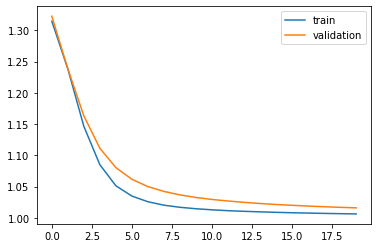

In [15]:
#Generamos plot con los resultados
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

## Resultados con valores de test

In [16]:
# make a prediction
yhat = model.predict(test_X)

In [24]:
inv_y, inv_yhat = full_prediction(yhat, test_X, test_y)


inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y[:,-1])


inv_yhat_df = pd.DataFrame(data=inv_yhat, columns=cols)
inv_y_df = pd.DataFrame(data=inv_y, columns=cols)


inv_y_df['log_ret'] = inv_y_df['Adj Close'].pct_change()


inv_yhat_df['log_ret'] = inv_yhat_df['Adj Close'].pct_change()

ValueError: non-broadcastable output operand with shape (675,1) doesn't match the broadcast shape (675,22)

In [ ]:
inv_y_df

In [ ]:
inv_yhat_df.head(60)

In [ ]:
res = pd.DataFrame({'yhat':inv_yhat[:,0], 'y':inv_y[:,0]})
res['res'] = res['yhat']*res['y']

lista =[]
for index, row in res.iterrows():
    if ((row['yhat'] > 0.5) and (row['y'] == 1)):
        lista.append('Acierto')
        
    elif ((row['yhat'] < 0.5) and (res['y'] == 0)):
        lista.append('Acierto')
    
    else:
        lista.append('Error')

serie = pd.Series(lista, index = res.index)

res['Resultado'] = serie



In [ ]:
pd.options.display.float_format = "{:,.11f}".format

res.head(60)

In [ ]:
print(res['Resultado'].value_counts())
print()
per = res['Resultado'].value_counts()[0]/(res['Resultado'].value_counts()[1]+res['Resultado'].value_counts()[0])
print(f'% acierto: {per}')